In [1]:
import os
os.chdir("D:/ML_Projects/MercedesBenz-Kaggle/")
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import GridSearchCV, ShuffleSplit, KFold
import sklearn.metrics as mt
from sklearn import svm, ensemble
from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNet
from sklearn.neural_network import MLPRegressor

D:\Anaconda\envs\ml_env\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
def read_data():
    train_data = pd.read_csv("./data/train.csv")
    test_data = pd.read_csv("./data/test.csv")
    return train_data, test_data


def process_data(train_data, test_data):
    binary_cols, all_zero_cols, all_one_cols = [],[],[]
    for col in train_data.iloc[:,10:]:
        unique_vals = train_data[col].unique()
        if np.array_equal(unique_vals, [1,0]) or np.array_equal(unique_vals, [0,1]):
            binary_cols.append(col)
        elif np.array_equal(unique_vals, [0]):
            all_zero_cols.append(col)
        elif np.array_equal(unique_vals, [1]):
            all_one_cols.append(col)
        else:
            print(unique_vals)

    # Drop columns with only zeros
    train_data = train_data.drop(all_zero_cols, axis=1)
    test_data = test_data.drop(all_zero_cols, axis=1)
    
    train_cat_cols = train_data.iloc[:,2:10]
    test_cat_cols = test_data.iloc[:,1:9]
    freq=[]
    col_names = []
    cat_mismatch = []
    
    for train_col, test_col in zip(train_cat_cols, test_cat_cols):
        col_names.append(train_col)
        train_freq = len(train_cat_cols[train_col].unique())
        test_freq = len(test_cat_cols[test_col].unique())
        
        if train_freq!=test_freq:
            cat_mismatch.append(train_col)
            
        freq.append([train_freq, test_freq])
    freq = pd.DataFrame(freq, columns=['Train_Freq', 'Test_Freq'], index=col_names)
    
    train_data = train_data.drop(cat_mismatch, axis=1)
    test_data = test_data.drop(cat_mismatch, axis=1)
    return train_data, test_data


def prepare_data_ml(train_data, test_data):
    X_train = pd.get_dummies(train_data)
    X_train = X_train.drop(['ID','y'], axis=1).values
    y_train = train_data.y.values
    
    X_test = pd.get_dummies(test_data)
    y_test_id = test_data.ID.values
    X_test = X_test.drop(['ID'], axis=1).values
    
    return X_train, y_train, X_test, y_test_id

def make_submission(reg_estimator, X_test, ID, fname='FinalSubmission'):
    y_pred = reg_estimator.predict(X_test)
    final_submission = pd.DataFrame(np.hstack([ID[:,np.newaxis], y_pred[:,np.newaxis]]), columns=['ID','y'])
    final_submission.ID = final_submission.ID.astype(int)
    final_submission.to_csv('./results/'+fname, index=False)
    return final_submission

In [3]:
def build_regressor(regressor_obj, X_train, y_train):
    print(regressor_obj)
    regressor_obj.fit(X_train, y_train)
    y_train_pred = regressor_obj.predict(X_train)
    
    r_2 = mt.r2_score(y_train, y_train_pred) # Coefficient of determination
    mse = mt.mean_squared_error(y_train, y_train_pred) # Mean squared error
    explained_var = mt.explained_variance_score(y_train, y_train_pred) # Explained variance
    
    print("Coefficient of Determination: ", r_2)
    print("Mean Square Error: ", mse)
    
    return regressor_obj, y_train_pred

In [4]:
train_data, test_data = read_data()
train_data, test_data = process_data(train_data, test_data)

X_train, y_train, X_test, y_test_id = prepare_data_ml(train_data, test_data)

print("Training Samples: ", X_train.shape)
print("Test Sample: ", X_test.shape)

Training Samples:  (4209, 431)
Test Sample:  (4209, 431)


In [5]:
print ("===============SVR Regression===============")
svr_regressor = svm.SVR(C=1.0, epsilon=0.1, gamma='auto',
                        kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
svr_regressor, svr_pred = build_regressor(svr_regressor, X_train, y_train)

print ("===============GBM Regression===============")
gbm_regressor = ensemble.GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse',
                                                   learning_rate=0.01, loss='ls', max_depth=3,
                                                   max_features='sqrt',
                                                   min_samples_split=2, min_weight_fraction_leaf=0.0,
                                                   n_estimators=1000, random_state=122,
                                                   subsample=1, verbose=0)
gbm_regressor, gbm_pred = build_regressor(gbm_regressor, X_train, y_train)

===============SVR Regression===============
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Coefficient of Determination:  0.541527816681
Mean Square Error:  73.6895526173
===============GBM Regression===============
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=122,
             subsample=1, verbose=0, warm_start=False)
Coefficient of Determination:  0.597975444419
Mean Square Error:  64.6168093065


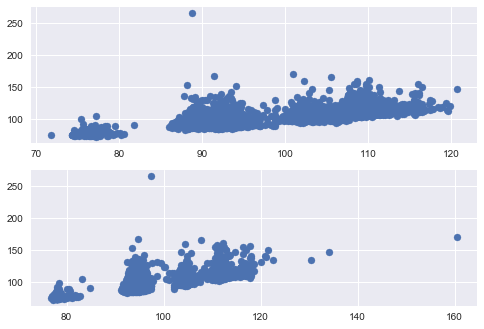

In [6]:
f, axarr = plt.subplots(2)
axarr[0].scatter(svr_pred, y_train)
axarr[1].scatter(gbm_pred, y_train)

## Stacking - Average of the predictions

### Ordinary Least Squares Regression

In [7]:
stacked_x_train = np.transpose(np.vstack((svr_pred, gbm_pred)))

In [8]:
from sklearn.linear_model import Ridge
stacked_lr = Ridge(alpha=0.0001, fit_intercept=True, normalize=True)
stacked_lr, stacked_pred = build_regressor(stacked_lr, stacked_x_train, y_train)

Ridge(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)
Coefficient of Determination:  0.600413038089
Mean Square Error:  64.2250184989


In [9]:
stacked_lr.coef_

array([-0.15680654,  1.21461296])

In [10]:
svr_test_pred = svr_regressor.predict(X_test)
gbm_test_pred = gbm_regressor.predict(X_test)

stacked_x_test = np.transpose(np.vstack((svr_test_pred, gbm_test_pred)))

stacked_lr_submission = make_submission(stacked_lr, stacked_x_test, y_test_id, "Stacked_Linear_Regression")

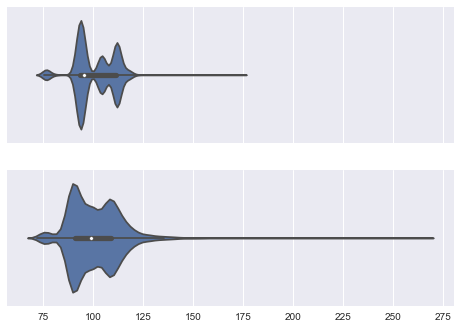

In [11]:
fig,axarr = plt.subplots(2, sharex=True)
sns.violinplot(stacked_pred, ax=axarr[0])
sns.violinplot(y_train, ax=axarr[1])